<a href="https://colab.research.google.com/github/boroju/aidl-upc-winter2024-satellite-imagery/blob/main/notebooks/jose/MODIS_ee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install odc-stac
!pip install planetary_computer
!pip install rioxarray
!pip install 'stackstac[viz]'
!pip install zen3geo
!pip install pyogrio[geopandas]
!pip install xbatcher
!pip install wxee

In [1]:
# Geospatial libraries
import pystac
import pystac_client
import planetary_computer
import rioxarray
# Deep Learning libraries
import torch
import torchdata
import zen3geo

In [2]:
print(f"pystac version: {pystac.__version__}")
print(f"planetary-computer version: {planetary_computer.__version__}")
print(f"torch version: {torch.__version__}")

print(f"torchdata version: {torchdata.__version__}")
print(f"zen3geo version: {zen3geo.__version__}")
rioxarray.show_versions()

pystac version: 1.9.0
planetary-computer version: 1.0.0
torch version: 2.1.0+cu121
torchdata version: 0.7.0
zen3geo version: 0.6.2
rioxarray (0.15.0) deps:
  rasterio: 1.3.9
    xarray: 2023.7.0
      GDAL: 3.6.4
      GEOS: 3.11.1
      PROJ: 9.0.1
 PROJ DATA: /usr/local/lib/python3.10/dist-packages/rasterio/proj_data
 GDAL DATA: /usr/local/lib/python3.10/dist-packages/rasterio/gdal_data

Other python deps:
     scipy: 1.11.4
    pyproj: 3.6.1

System:
    python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
executable: /usr/bin/python3
   machine: Linux-6.1.58+-x86_64-with-glibc2.35


In [3]:
import ee
import wxee

ee.Authenticate()
ee.Initialize(project='ee-joseramoncajide')


In [4]:
wxee.Initialize()

# Fire Progressions

*Before going deeply into Dixie widlfire ...*

**Daily Progressions from MODIS**

One of the products captured by the MODIS sensor is fire hotspot detections. We’ll use wxee to load daily hotspots for the  *2021 Caldor fire in California* and visualize them by the time of burning.

In [11]:
modis = wxee.TimeSeries("MODIS/006/MOD14A1").filterDate("2021-08-15", "2021-09-05").select("FireMask")

modis.describe()

MODIS/006/MOD14A1
	Images: 21
	Start date: 2021-08-15 00:00:00 UTC
	End date: 2021-09-04 00:00:00 UTC
	Mean interval: 1.00 days


The FireMask band contains codes indicating the confidence of fire detections. First, we’ll use map to turn those codes into binary images of fire presence, copying properties over so we don’t lose any time information.

In [13]:
fire_masks = modis.map(lambda img: img.eq(9).copyProperties(img, img.propertyNames()))
fire_masks.describe()

MODIS/006/MOD14A1
	Images: 21
	Start date: 2021-08-15 00:00:00 UTC
	End date: 2021-09-04 00:00:00 UTC
	Mean interval: 1.00 days


Now we’ll specify a bounding box around the Caldor fire and download the TimeSeries to an xarray.Dataset.

In [14]:
region = ee.Geometry.Polygon(
        [[[-120.70580745719522, 38.90798203224902],
          [-120.70580745719522, 38.51793451346024],
          [-119.90014827750772, 38.51793451346024],
          [-119.90014827750772, 38.90798203224902]]]
)

ds = fire_masks.wx.to_xarray(scale=1000, region=region, crs="EPSG:26910")
display(ds)

Requesting data:   0%|          | 0/21 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:      (time: 21, x: 73, y: 47)
Coordinates:
  * time         (time) datetime64[ns] 2021-08-15 2021-08-16 ... 2021-09-04
  * x            (x) float64 6.985e+05 6.995e+05 ... 7.695e+05 7.705e+05
  * y            (y) float64 4.312e+06 4.31e+06 4.31e+06 ... 4.266e+06 4.266e+06
    spatial_ref  int64 0
Data variables:
    FireMask     (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768
    scale_factor:            1.0
    add_offset:              0.0

Visualizing the Progression

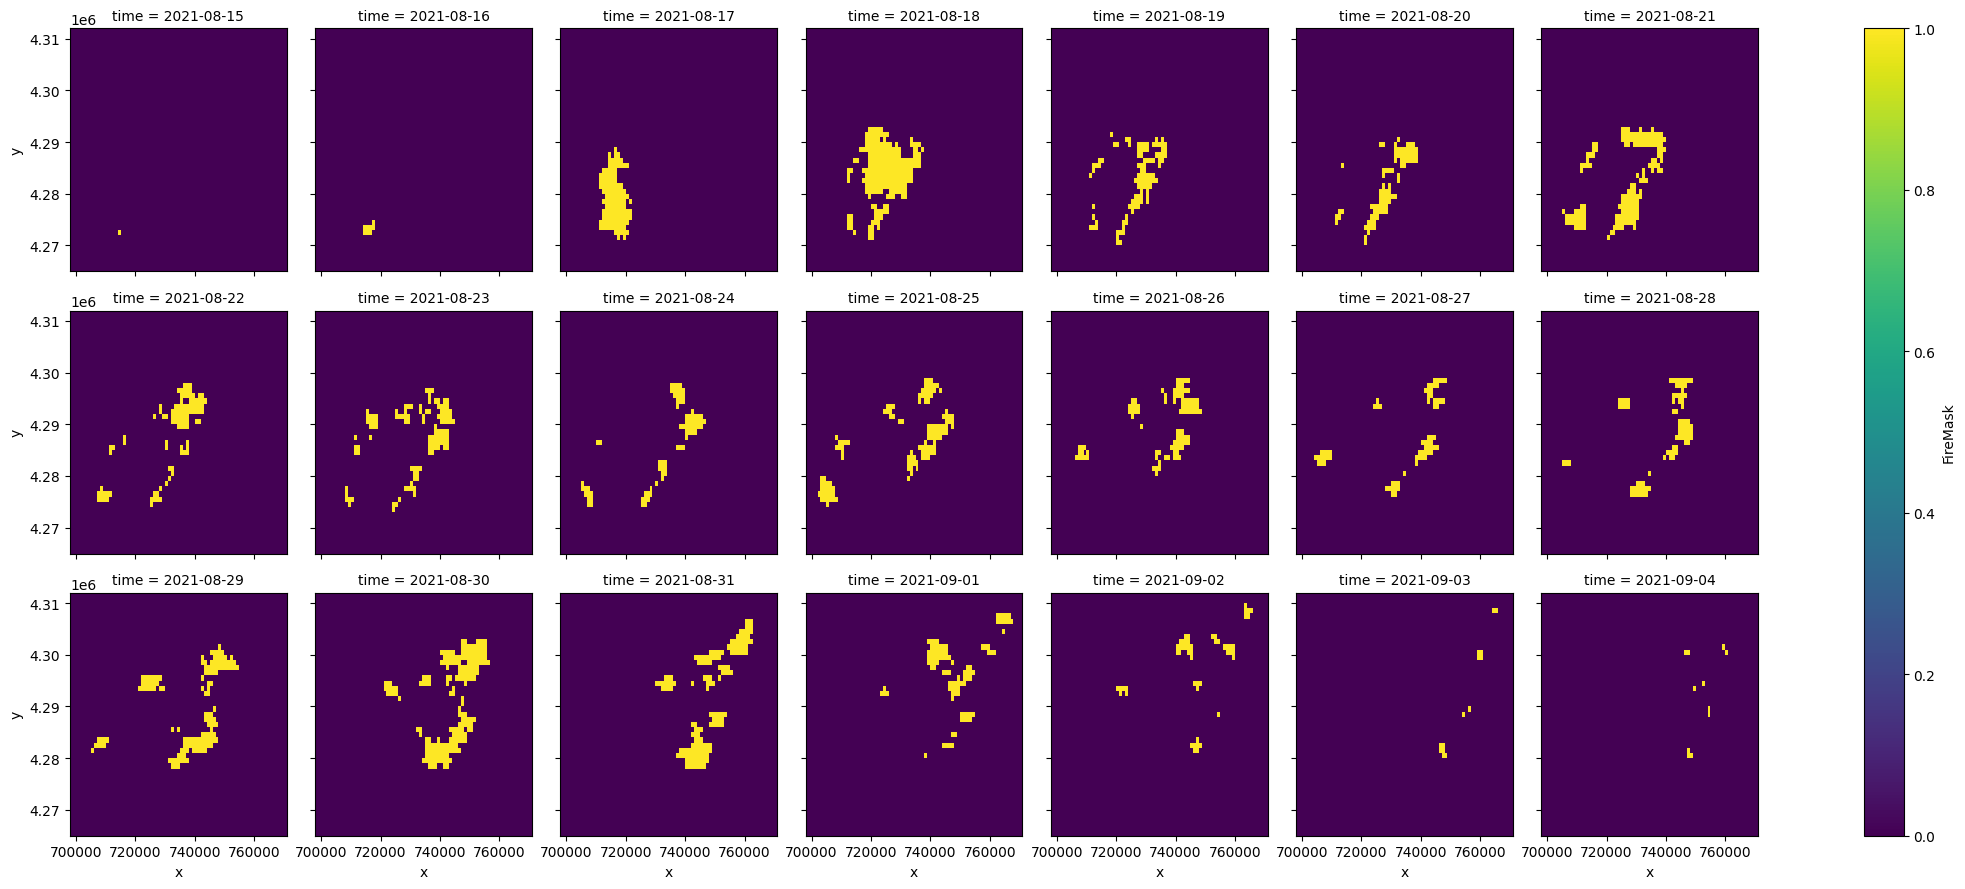

In [16]:
ds.FireMask.plot(col="time", col_wrap=7)

We want a single summary image describing that progression. Let’s calculate the first day that a given pixel burned. Rather than storing specific times, we’ll represent them as time elapsed since the beginning of the time series.

In [20]:
start = ds.time.min()
display(start)
print("")
delta_days = (ds.time - start).dt.days
display(delta_days)

<xarray.DataArray 'time' ()>
array('2021-08-15T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int64 0

<xarray.DataArray 'days' (time: 21)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])
Coordinates:
  * time         (time) datetime64[ns] 2021-08-15 2021-08-16 ... 2021-09-04
    spatial_ref  int64 0

Now, we’ll multiply the time delta by the fire mask. Because non-fire pixels have a value of 0, this will give us a 3D array with elapsed days since start for each hotspot pixel and values of 0 for all other pixels. We cast from a timedelta to an int to allow plotting.

In [24]:
delta_days_fire = (ds.FireMask * delta_days).astype(int)
display(delta_days_fire)


<xarray.DataArray (time: 21, y: 47, x: 73)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates:
  * time         (time) datetime64[ns] 2021-08-15 2021-08-16 ... 2021-09-04
  * x            (x) float64 6.985e+05 6.995e+05 ... 7.695e+05 7.705e+05
  * y            (y) float64 4.312e+06 4.31e+06 4.31e+06 ... 4.266e+06 4.266e+06
    spatial_ref  int64 0

Finally, we can mask non-hotspot pixels (values of 0) and take the minimum over time to get the first time, in days elapsed since start, that each pixel burned.

In [25]:
first_burned = delta_days_fire.where(delta_days_fire != 0).min("time")
display(first_burned)

<xarray.DataArray (y: 47, x: 73)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 6.985e+05 6.995e+05 ... 7.695e+05 7.705e+05
  * y            (y) float64 4.312e+06 4.31e+06 4.31e+06 ... 4.266e+06 4.266e+06
    spatial_ref  int64 0

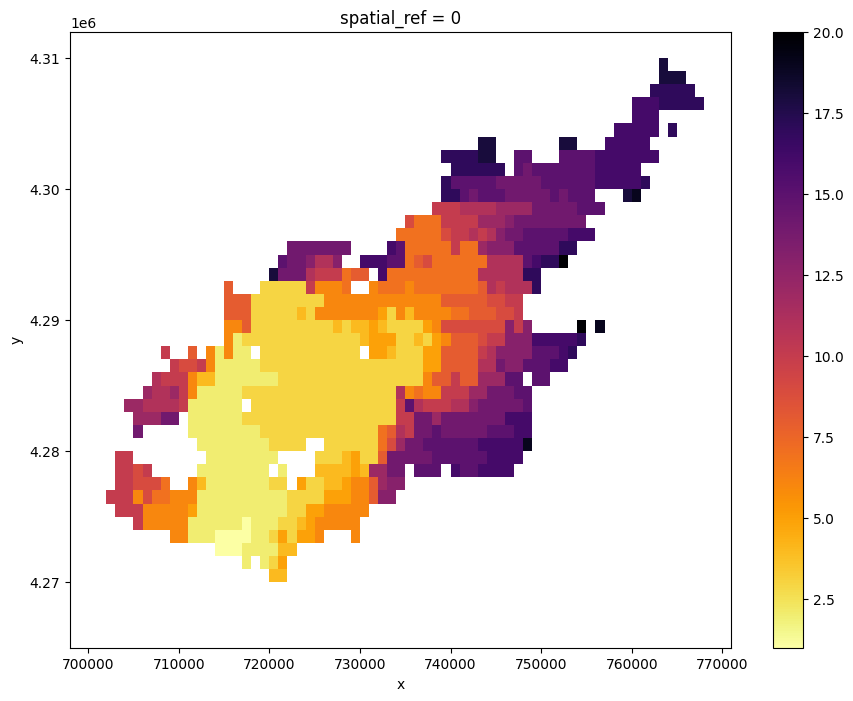

In [26]:
first_burned.plot(size=8, cmap="inferno_r")

# 2021 Dixie Wildfire in California



```
0: Not processed (missing input data)
1: Not processed (obsolete; not used since Collection 1)
2: Not processed (other reason)
3: Non-fire water pixel
4: Cloud (land or water)
5: Non-fire land pixel
6: Unknown (land or water)
7: Fire (low confidence, land or water)
8: Fire (nominal confidence, land or water)
9: Fire (high confidence, land or water)
```



In [32]:
# 2021 Dixie Wildfire in California
latitude = 40.7310
longitude = -122.9420
location = [longitude, latitude]
# area_of_interest or geometry
area_of_interest = {
    "type": "Point",
    "coordinates": location,
}
datetimes = [
    "2021-07-12",
    "2021-07-20",
    "2021-07-28",
    "2021-08-05",
    "2021-08-13",
    "2021-08-21",
]

print(area_of_interest)
buffer = 0.7
bbox = [longitude - buffer, latitude - buffer, longitude + buffer, latitude + buffer]
print(bbox)

{'type': 'Point', 'coordinates': [-122.942, 40.731]}
[-123.642, 40.031, -122.24199999999999, 41.431000000000004]


Transform bbox to Earth Engine region for later usage:

A bounding box (usually shortened to bbox) is an area defined by two longitudes and two latitudes.

In [6]:
from shapely import geometry
bbox_polygon = geometry.box(*bbox)
print(bbox_polygon.wkt)

region = ee.Geometry.Polygon(
        list(bbox_polygon.exterior.coords)
)
# print(region)

POLYGON ((-122.24199999999999 40.031, -122.24199999999999 41.431000000000004, -123.642 41.431000000000004, -123.642 40.031, -122.24199999999999 40.031))


Thermal Anomalies/Fire Daily (14A1)

Thermal Anomalies/Fire 8-Day (14A2)

In [38]:
#modis = wxee.TimeSeries("MODIS/006/MOD14A1").filterDate("2021-08-15", "2021-09-05").select("FireMask")

# range = "2021-07-12/2021-08-21"
# MOD14A2 => Weekly
# ok modis = wxee.TimeSeries("MODIS/061/MOD14A1").filterDate("2021-08-15", "2021-09-05").select("FireMask")
modis = wxee.TimeSeries("MODIS/061/MOD14A1").filterDate("2021-07-30", "2021-09-05").select("FireMask")

#ESTO https://developers.google.com/earth-engine/datasets/catalog/FIRMS#bands
# modis = wxee.TimeSeries("MODIS/061/MCD15A3H").filterDate("2021-07-12", "2021-08-21").select("Lai")

## The FireMask band contains codes indicating the confidence of fire detections. First, we’ll use map to turn those codes into binary images of fire presence, copying properties over so we don’t lose any time information.
## ESTO PARA MCD15A3H => fire_masks = modis.map(lambda img: img.eq(9).copyProperties(img, img.propertyNames()))


Example on how to apply a function to process, e.g. filter and rename a mask:

In [39]:
# MOD14A1 only
def fire_mask(img):
    mask = ee.Image(0).rename("fire")
    # mask = (mask
    #     .where(img.eq(9), 1)
    #     .where(img.eq(8), 1)
    #     .where(img.eq(7), 1)
    # )
    mask = (mask
        .where(img.gte(7), 1)
    )
    # Copy the properties from the original images to avoid losing time data.
    return mask.copyProperties(img, img.propertyNames())

# Convert each mask class image into a binary fire presence mask
# fire_masks = modis.map(lambda img: fire_mask(img))
# fire_masks

In [40]:
fire_masks = modis.map(lambda img: img.gte(7).copyProperties(img, img.propertyNames()))

MODIS imagery is [unbounded](https://github.com/aazuspan/wxee/blob/main/docs/examples/modis.ipynb), so we need to specify a `region`
 when we convert it to an xarray.Dataset. Now we’ll specify a bounding box around the Dixie fire and download the TimeSeries to an xarray.Dataset.

In [41]:
ds = fire_masks.wx.to_xarray(scale=1000, region=region, crs="EPSG:26910")

Requesting data:   0%|          | 0/37 [00:00<?, ?it/s]

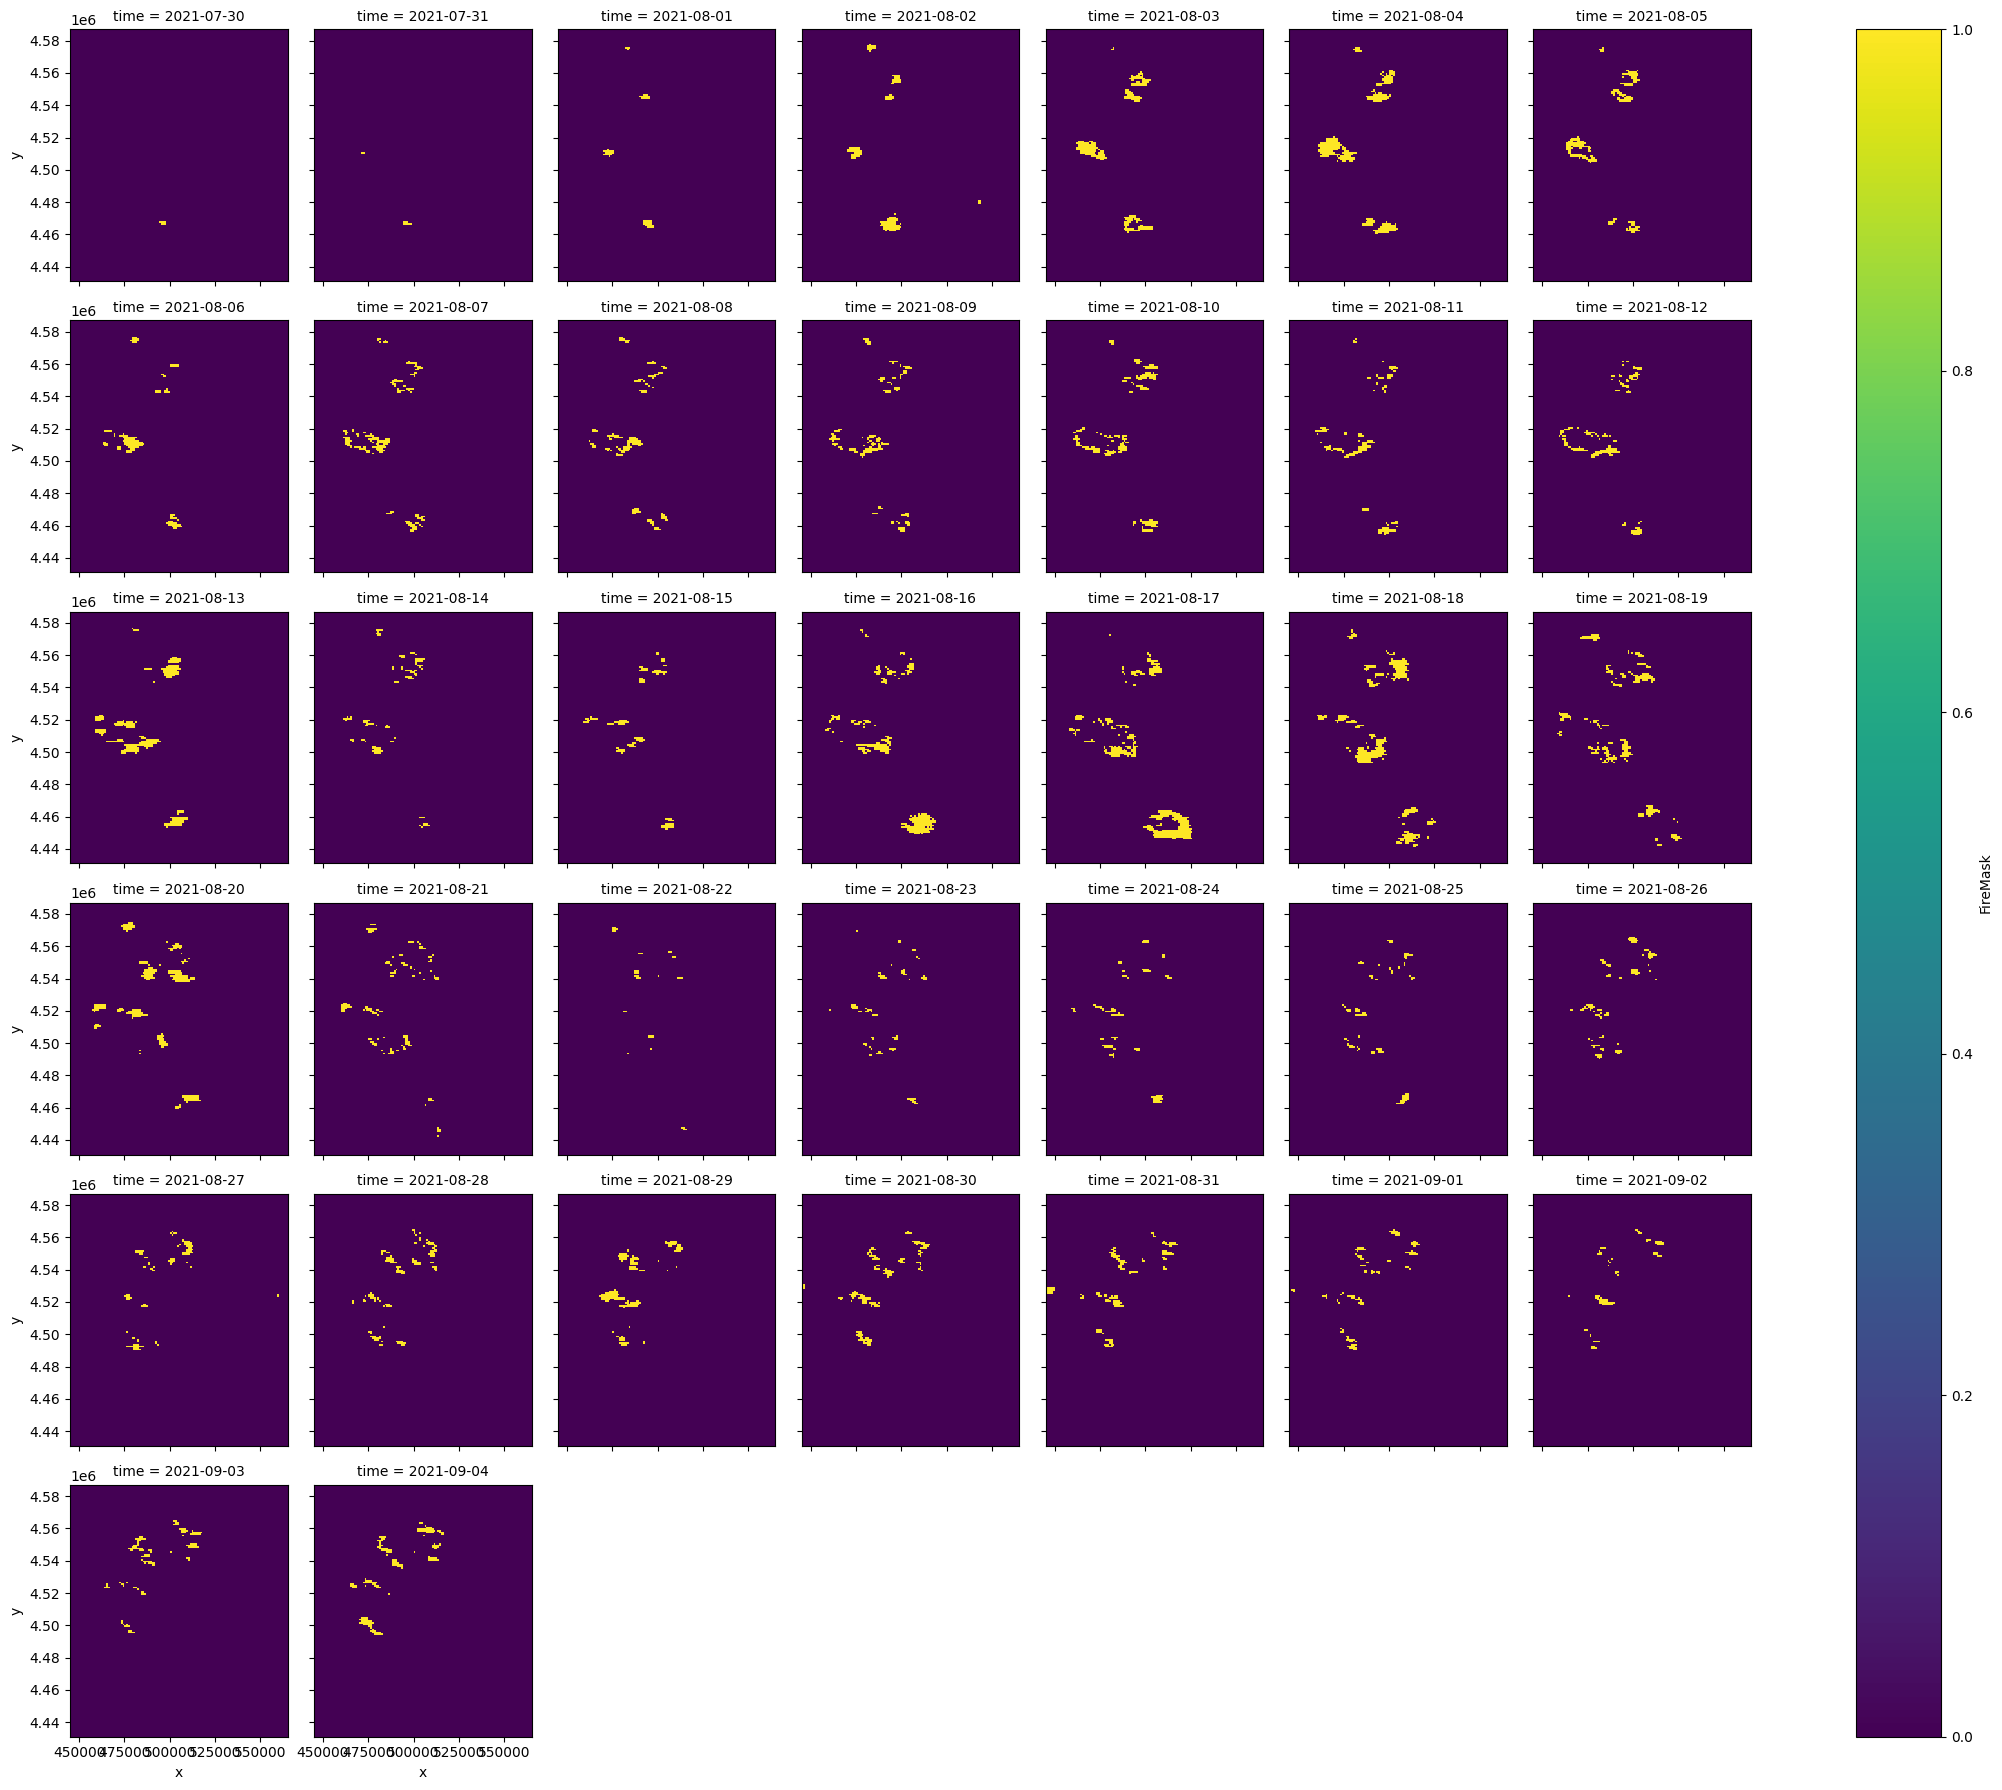

In [42]:
ds.FireMask.plot(col="time", col_wrap=7)

### Mean

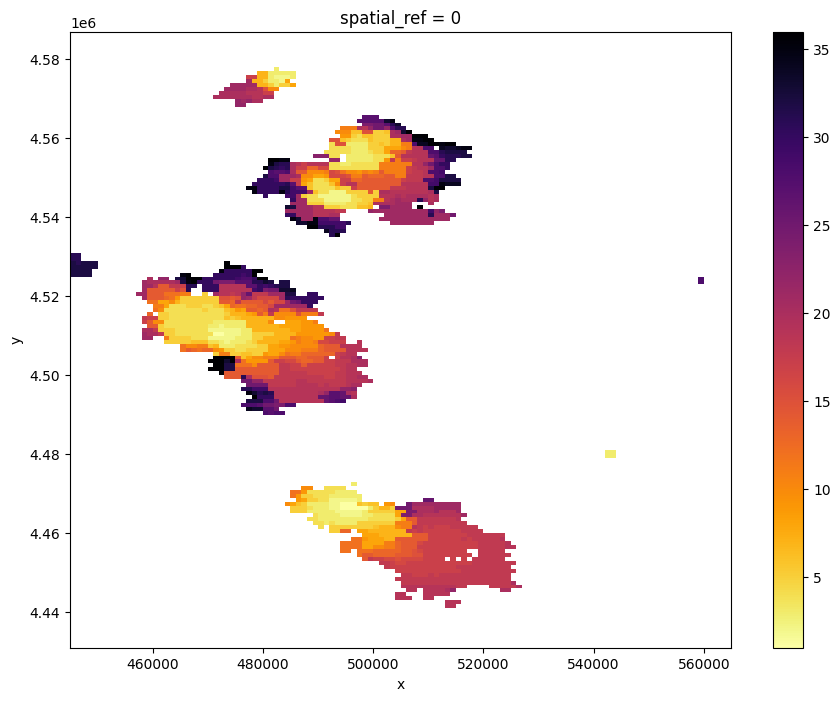

In [43]:
def get_fire_progession(ds):
  start = ds.time.min()
  delta_days = (ds.time - start).dt.days
  delta_days_fire = (ds.FireMask * delta_days).astype(int)
  first_burned = delta_days_fire.where(delta_days_fire != 0).min("time")
  return first_burned


fire_progession = get_fire_progession(ds)
fire_progession.plot(size=8, cmap="inferno_r")

In [44]:
fire_masks_df = fire_masks.dataframe()
fire_masks_df

,system:id,system:time_start,MaxFRP_scale
0,MODIS/061/MOD14A1/2021_07_30,2021-07-30,0.1
1,MODIS/061/MOD14A1/2021_07_31,2021-07-31,0.1
2,MODIS/061/MOD14A1/2021_08_01,2021-08-01,0.1
3,MODIS/061/MOD14A1/2021_08_02,2021-08-02,0.1
4,MODIS/061/MOD14A1/2021_08_03,2021-08-03,0.1
5,MODIS/061/MOD14A1/2021_08_04,2021-08-04,0.1
6,MODIS/061/MOD14A1/2021_08_05,2021-08-05,0.1
7,MODIS/061/MOD14A1/2021_08_06,2021-08-06,0.1
8,MODIS/061/MOD14A1/2021_08_07,2021-08-07,0.1
9,MODIS/061/MOD14A1/2021_08_08,2021-08-08,0.1


In [45]:
import random

sample_image = random.choice(fire_masks_df["system:id"].values)
sample_image

'MODIS/061/MOD14A1/2021_09_01'

In [46]:
img = ee.Image(sample_image).select(["FireMask"])
img

In [47]:
# Clip the image
geom_poly = ee.Geometry.BBox(*bbox)
img = img.clip(geom_poly)

In [66]:
# Conver image to ds: https://geemap.org/notebooks/140_ee_to_xarray/
_ds = geemap.ee_to_xarray(img)
_ds

<xarray.Dataset>
Dimensions:   (time: 1, lon: 360, lat: 180)
Coordinates:
  * time      (time) datetime64[ns] 2021-09-01
  * lon       (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat       (lat) float64 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
Data variables:
    FireMask  (time, lon, lat) int32 ...
Attributes:
    crs:      EPSG:4326

In [48]:
bbox_centroid = geom_poly.centroid(maxError=1)
# display('bbox.centroid(...) =', bbox_centroid)

In [49]:
import geemap

Map = geemap.Map(center=[40.72925142342754, -122.94200000000065, ], zoom=8)

# TODO: https://tutorials.geemap.org/Image/image_visualization/
firemask_vis = {'bands': ['FireMask'],
               #'min': 0,
               #'max': 0.5,
               'gamma': 0.4}

Map.addLayer(img, firemask_vis, "FireMask")


Map

Map(center=[40.72925142342754, -122.94200000000065], controls=(WidgetControl(options=['position', 'transparent…

In [63]:
period_max = fire_masks.aggregate_time("week", reducer=ee.Reducer.max())
period_max

In [61]:
ds = period_max.wx.to_xarray(region=region, scale=1000, crs="EPSG:26910")

Requesting data:   0%|          | 0/6 [00:00<?, ?it/s]

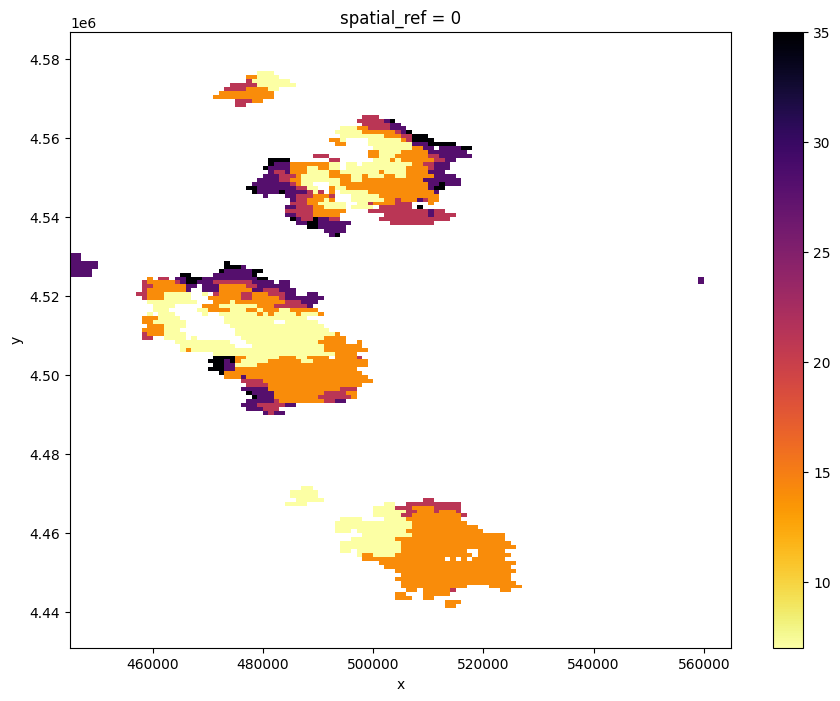

In [62]:
fire_progession = get_fire_progession(ds)
fire_progession.plot(size=8, cmap="inferno_r")

In [64]:
task = ee.batch.Export.image.toDrive(landsat, 'TEST_todrive', **task_config)
task.start()

<xarray.Dataset>
Dimensions:      (time: 6, x: 120, y: 156)
Coordinates:
  * time         (time) datetime64[ns] 2021-07-30 2021-08-06 ... 2021-09-03
  * x            (x) float64 4.455e+05 4.465e+05 ... 5.635e+05 5.645e+05
  * y            (y) float64 4.586e+06 4.586e+06 ... 4.432e+06 4.432e+06
    spatial_ref  int64 0
Data variables:
    FireMask     (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768
    scale_factor:            1.0
    add_offset:              0.0

# Download

https://gis.stackexchange.com/questions/376717/export-multiple-images-from-collection-to-google-drive-not-working-with-google-e

In [72]:
# USDA NAIP ImageCollection
collection = ee.ImageCollection('MODIS/061/MOD14A1')

# create a roi
polys = ee.Geometry.Polygon(
        [[[37.5, 25.5],
          [40.5, 25.5],
          [40.5, 28.5],
          [37.5, 28.5]]])

# filter the ImageCollection using the roi
modis_collection = collection.filterBounds(region)

# filter dates
modis_dates = modis_collection.filterDate('2021-07-30', '2021-09-05').select("FireMask")
mosaic = modis_dates.mosaic()

# print out the number of images in the ImageCollection
count = modis_dates.size().getInfo()
print("Count: ", count)

Count:  37


In [73]:
# export the ImageCollection to Google Drive
img_lst = modis_dates.toList(100)
img_lst

In [69]:
import time
for i in range(0, count):
    image = ee.Image(img_lst.get(i))
    name = image.get('system:index').getInfo()
    task = ee.batch.Export.image.toDrive(image=image,
                                         region=region,
                                         folder='MODIS_MOD14A1',
                                         scale=30,
                                         crs='EPSG:26910')
    task.start()
    print(task.status())

    while task.active():
      print('Waiting on (id: {}).'.format(task.id))
      time.sleep(15)


{'state': 'READY', 'description': 'myExportImageTask', 'creation_timestamp_ms': 1705845495652, 'update_timestamp_ms': 1705845495652, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': 'I5ZDFM5Y7QS2IWB332V3B2ET', 'name': 'projects/earthengine-legacy/operations/I5ZDFM5Y7QS2IWB332V3B2ET'}
{'state': 'READY', 'description': 'myExportImageTask', 'creation_timestamp_ms': 1705845496699, 'update_timestamp_ms': 1705845496699, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': 'JECZQSMCDYNKJZJBBRYTLJZ4', 'name': 'projects/earthengine-legacy/operations/JECZQSMCDYNKJZJBBRYTLJZ4'}
{'state': 'READY', 'description': 'myExportImageTask', 'creation_timestamp_ms': 1705845497403, 'update_timestamp_ms': 1705845497403, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': 'FK4VYLSY2V4V2RTGAFRUKSWR', 'name': 'projects/earthengine-legacy/operations/FK4VYLSY2V4V2RTGAFRUKSWR'}
{'state': 'READY', 'description': 'myExportImageTask', 'creation_timestamp_ms': 1705845498195, 'update_timestamp

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [79]:
!ls "/content/drive/My Drive/MODIS_MOD14A1"

'myExportImageTask (1).tif'  'myExportImageTask (3).tif'
'myExportImageTask (2).tif'   myExportImageTask.tif
